# Import des Netzwerks für das Modell

### Einrichtung

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math

import pypsa

%matplotlib inline

## Setup

Einrichtung aller wichtigen Kompnenten und Einlesen der Daten

Die jeweiligen Daten entstammen einer anderen Bachelorarbeit und werden über die von pandas zur Verfügung gestellten Funktionen aus Excel-Dateien eingelesen und als Dataframe gespeichert. Aus diesem werden dann wiederum nur die benötigten Werte verwendet.

### Variablen

In [2]:
nw = pypsa.Network()

In [19]:
# dates = pd.date_range("2015-11-01T04:00:00Z", periods=5, freq="4H")

# nw.set_snapshots(dates)
nw.set_snapshots(["morgens", "mittags", "abends"])

In [4]:
cur_path = r"C:\Users\janni\OneDrive\TU Berlin\4 - Abschlussarbeiten\01 - Bachelorarbeit\modell\data\\"

### Einlesen der Datenbanken

In [5]:
ex1 = pd.ExcelFile(cur_path + "map_cities.xlsx")
ex2 = pd.ExcelFile(cur_path + "map_countries.xlsx")

all_gens = pd.read_excel(cur_path + "Kraftwerksliste_ÜNB_Entwurf_Szenariorahmen_2030_V2019.xlsx")

### Aufbau Inland

In [6]:
df_buses = pd.read_excel(ex1, sheetname="buses", header=0, parse_cols="B:D")
df_lines = pd.read_excel(ex1, sheetname="lines", header=0, parse_cols="B:D")

C:\Users\janni\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  """Entry point for launching an IPython kernel.
C:\Users\janni\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
C:\Users\janni\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  


### Aufbau Ausland

Calculating the length of each line by Pythagoras.
The factor enables converting the distance in lattitude/longitude to kilometers

In [7]:
df_lines["length"] = 0
factor_coords_to_km = 111

for i in range(len(df_lines)):
    x_val = df_buses["x"][df_lines["bus0"][i]] - df_buses["x"][df_lines["bus1"][i]]
    y_val = df_buses["y"][df_lines["bus0"][i]] - df_buses["y"][df_lines["bus1"][i]]
    df_lines.at[i, "length"] = (math.sqrt(x_val**2 + y_val**2) * factor_coords_to_km)

In [8]:
pypsa.io.import_components_from_dataframe(nw, df_buses, "Bus")

In [9]:
pypsa.io.import_components_from_dataframe(nw, df_lines, "Line")

(<matplotlib.collections.PathCollection at 0x1bb47ebd160>,
 <matplotlib.collections.LineCollection at 0x1bb47d846a0>)

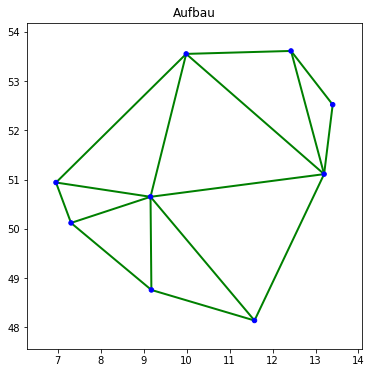

In [10]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches(6,6)

nw.plot(bus_sizes=20, title="Aufbau")

### Generators

In [11]:
# only active generators
filtered = all_gens.loc[all_gens["Status 31.12.2016"]=="In Betrieb"]
# take the most powerful of each type of generator for each of the ÜNB
filtered = filtered.groupby([all_gens["Energieträger"], all_gens["ÜNB"]]).max()
# only 3 kinds of energysource
classic_gens = filtered[(filtered.Energieträger=="Braunkohle") | (filtered.Energieträger=="Steinkohle") | (filtered.Energieträger=="Erdgas")]
# get rid of multiple index columns
classic_gens.reset_index(drop=True, inplace=True)
# Vereinfachung der Indizes
classic_gens = classic_gens[["Betreiber", "Energieträger", "ÜNB", "Bundesland", "Nettoleistung 31.12.2016 [MW]"]].copy()

Add correct busnumber to each generator by comparing regions from df with buses

In [12]:
classic_gens["bus"] = 0

for j in range(len(classic_gens)):
    # find out index of "Bundesland" of each generator
    indices = [i for i, s in enumerate(nw.buses.name) if classic_gens["Bundesland"][j] in s]
    classic_gens.at[j, "bus"] = indices[0]

In [13]:
classic_gens.rename(columns={"Betreiber":"name",
                             "Energieträger":"carrier",
                             "Nettoleistung 31.12.2016 [MW]":"p_nom"}, inplace=True)
classic_gens["committable"] = True

Zuerst werden die zur Verfügung gestellten Daten eingelesen, danach werden diese noch um einige benötigte Werte von Hand erweitert, die zur Durchführung des Unit Commitment nötig sind

Uebertragen der Daten von pandas in das Netzwerk

In [14]:
nw.generators.p_nom.sum()

0.0

### Temporary Loads for testing

Einlesen der Werte pro Zeitintervall

In [16]:
nw.add("Load", "myload0", bus=0, p_set=500)

In [17]:
nw.add("Generator", "myload0", bus=0, p_nom=600)

## Aufbereitung der Daten

In [20]:
nw.lopf(solver_name="gurobi")

INFO:pypsa.pf:Slack bus for sub-network 0 is 0
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
C:\Users\janni\Anaconda3\lib\site-packages\pypsa\opf.py:686: RuntimeWarning: divide by zero encountered in double_scalars
  y = 1/ passive_branches.at[ branch, attribute]
C:\Users\janni\Anaconda3\lib\site-packages\pypsa\opf.py:691: RuntimeWarning: invalid value encountered in double_scalars
  -y*(passive_branches.at[branch,"phase_shift"]*np.pi/180. if bt == "Transformer" else 0.))
INFO:pypsa.opf:Solving model using gurobi


AssertionError: 

## Visualization

In [ ]:
gen_outs = nw.generators_t.p
caps_by_carrier = nw.generators.groupby("carrier")["p_nom"].sum()
gen_pot_remaining = nw.generators.p_nom - gen_outs

Line graph to display the dispatched amount of energy per plant

In [ ]:
gen_plot = gen_outs.plot(kind="area",grid=True)
lines, labels = gen_plot.get_legend_handles_labels()
gen_plot.legend(lines[:len(nw.generators)], nw.generators['name'].values.tolist(), loc='best')
plt.ylabel("MW")

network graph showing the distribution of buses etc.

In [ ]:
nw.generators_t.p_nom_opt